<a href="https://colab.research.google.com/github/carol1521/2-tier-Argumentation-Framework/blob/main/Yan_claim_identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Claim_detection

## Reading_data

In [ ]:
!pip install scikit-plot

In [ ]:
import tensorflow as tf

In [ ]:
import numpy as np
import pandas as pd
import string
import nltk
import gensim
import os
import warnings
import matplotlib.pyplot as plt
import scikitplot as skplt
import networkx as nx
 
from nltk.tokenize.punkt import PunktSentenceTokenizer
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer

from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import f1_score, recall_score, precision_score

from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense, Flatten,TimeDistributed,LSTM
from keras.callbacks import EarlyStopping, ModelCheckpoint

%notebook inline
warnings.filterwarnings("ignore")
root_train = os.getcwd() + '/gdrive/MyDrive/Yan/IBM_Debater_(R)_CS_EACL-2017.v1/'
root_test = os.getcwd() + '/drive/MyDrive/Yan/IBM_Debater_(R)_CE-ACL-2014.v0'
print(root_train)
print(root_test)

/content/gdrive/MyDrive/Yan/IBM_Debater_(R)_CS_EACL-2017.v1/
/content/drive/MyDrive/Yan/IBM_Debater_(R)_CE-ACL-2014.v0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def read_file(filename):
    data = []
    with open(filename, 'r') as f:
        text = f.read().split('\n')
        for parag in text:
            if len(parag) >2:
                data = data + [a for a in parag.split('. ') if len(a)>0]
                
    return data

In [ ]:
articles_train = dict()
for subdir, dirs, files in os.walk('/content/drive/MyDrive/Yan/IBM_Debater_(R)_CS_EACL-2017.v1/articles'):
    for file in files:
        if file[-3:] == 'txt' and file[:5] == 'clean':
            filename = os.path.join(subdir, file)
            articles_train[file] = read_file(filename)

In [ ]:
articles_test = dict()
for subdir, dirs, files in os.walk('/content/drive/MyDrive/Yan/IBM_Debater_(R)_CE-ACL-2014.v0/wiki12_articles'):
 

    for file in files:
        #if file[-3:] == 'txt' and file[:5] == 'clean':
        filename = os.path.join(subdir, file)
        print(filename)
        articles_test[file] = read_file(filename)


In [ ]:
claimDF_train= pd.read_csv("/content/drive/MyDrive/Yan/IBM_Debater_(R)_CS_EACL-2017.v1/claim_stance_dataset_v1.csv")
article_paths_train = set(claimDF_train['claims.article.cleanFile'])
print(article_paths_train)

In [ ]:
claimDF_test = pd.read_excel("/content/drive/MyDrive/Yan/IBM_Debater_(R)_CE-ACL-2014.v0/2014_7_18_ibm_CDCdata(cleaned_2).xlsx")
article_paths_test = set(claimDF_test['Article'])
print(article_paths_test)

In [ ]:
claimDF_train[:1].T

,0
topicId,1
split,test
topicText,This house believes that the sale of violent v...
topicTarget,the sale of violent video games to minors
topicSentiment,-1
claims.claimId,2973
claims.stance,PRO
claims.claimCorrectedText,Exposure to violent video games causes at leas...
claims.claimOriginalText,exposure to violent video games causes at leas...
claims.article.rawFile,articles/t1/raw_1.txt


In [ ]:
claimDF_test[:1].T

,0
Topicc,the sale of violent video games to minors
Article,Video_game_controversies
Claim,exposure to violent video games causes at leas...
Requires correction,True
Correction type,NaN
Corrected Text,Exposure to violent video games causes at leas...


In [ ]:
def textrank(sentences):
#     sentence_tokenizer = PunktSentenceTokenizer()
#     sentences = sentence_tokenizer.tokenize(document)
 
    bow_matrix = CountVectorizer().fit_transform(sentences)
    normalized = TfidfTransformer().fit_transform(bow_matrix)
 
    similarity_graph = normalized * normalized.T
 
    nx_graph = nx.from_scipy_sparse_matrix(similarity_graph)
    scores = nx.pagerank(nx_graph)
    
    return dict((s, scores[i]) for i,s in enumerate(sentences))

In [ ]:
articles_tags_train = []
articles_sent_length_train = []
sentences_train = []
topics_train = []
article_locs_train = []
article_rank_train = []

for a in article_paths_train:
    article_name = a.split('/')[-1]
    #print(article_name)
    #print(articles)
    
    sents = articles_train[article_name]
    rank_dict = textrank(sents)
    claims = list(claimDF_train[claimDF_train['claims.article.cleanFile'] == a]['claims.claimOriginalText'])
    topic = list(claimDF_train[claimDF_train['claims.article.cleanFile'] == a]['topicTarget'])[0]
    tags = []
    sent_length = []
    locs = []
    rank = []
    
    for i, sent in enumerate(sents):
        # get normalized location
        locs.append(i+1/float(len(sents)))
        
        # get text rank score
        r = rank_dict[sent]
        rank.append(r)
        
        # get sent length
        tokens = [a for a in sent.split() if a != '']
        sent_length.append(len(tokens))
        
        topics_train.append(topic)
        flag = False
        for claim in claims:
            if claim in sent:
                tags.append(1)
                claims.remove(claim)
                flag = True
                break
        if not flag:
            tags.append(0)  
    
    sentences_train.append(sents)
    articles_tags_train.append(tags)
    article_locs_train.append(locs)
    articles_sent_length_train.append(sent_length)
    article_rank_train.append(rank)
    

In [ ]:
d_train = {'sentences': sum(sentences_train, []), 
     'topic': topics_train, 
     'length': sum(articles_sent_length_train, []), 
     'label': sum(articles_tags_train, []),
    'loc': sum(article_locs_train, []),
    'rank': sum(article_rank_train, [])}
df_train = pd.DataFrame(d_train)

In [ ]:
#test
articles_tags_test = []
articles_sent_length_test = []
sentences_test = []
topics_test = []
article_locs_test = []
article_rank_test = []

for a in article_paths_test:
    article_name = a.split('/')[-1]
    print(article_name)
    #print(articles)
    
    sents = articles_test[article_name]
    rank_dict = textrank(sents)
    claims = list(claimDF_test[claimDF_test['Article'] == a]['Claim'])
    topic = list(claimDF_test[claimDF_test['Article'] == a]['Topicc'])[0]
    tags = []
    sent_length = []
    locs = []
    rank = []
    
    for i, sent in enumerate(sents):
        # get normalized location
        locs.append(i+1/float(len(sents)))
        
        # get text rank score
        r = rank_dict[sent]
        rank.append(r)
        
        # get sent length
        tokens = [a for a in sent.split() if a != '']
        sent_length.append(len(tokens))
        
        topics_test.append(topic)
        flag = False
        for claim in claims:
            if claim in sent:
                tags.append(1)
                claims.remove(claim)
                flag = True
                break
        if not flag:
            tags.append(0)  
    
    sentences_test.append(sents)
    articles_tags_test.append(tags)
    article_locs_test.append(locs)
    articles_sent_length_test.append(sent_length)
    article_rank_test.append(rank)
    

In [ ]:
#test
d_test = {'sentences': sum(sentences_test, []), 
     'topic': topics_test, 
     'length': sum(articles_sent_length_test, []), 
     'label': sum(articles_tags_test, []),
    'loc': sum(article_locs_test, []),
    'rank': sum(article_rank_test, [])}
df_test = pd.DataFrame(d_test)

In [ ]:
#test
data_test= list(zip(sum(sentences_test, []), topics_test,\
           sum(articles_sent_length_test, []), sum(articles_tags_test, []), \
           sum(article_locs_test, []),sum(article_locs_test, [])))

# sentence, topic, length, label, loc, rank

## feature

In [ ]:
def get_word2vec(sentences, location):
    """Returns trained word2vec
    
    Args:
        sentences: iterator for sentences
        
        location (str): Path to save/load word2vec
    """
    if os.path.exists(location):
        print('Found {}'.format(location))
        model = gensim.models.Word2Vec.load(location)
        return model
    
    print('{} not found. training model'.format(location))
    model = gensim.models.Word2Vec(sentences, size=100, window=5, min_count=5, workers=4)
    print('Model done training. Saving to disk')
    model.save(location)
    return model

class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(word2vec.wv.syn0[0])

    def fit(self, X, y=None):
        return self

    def transform(self, X):
#         X = MyTokenizer().fit_transform(X)

        X = X.split(' ')
        emb = []
        for word in X:
            if word in self.word2vec.wv:
                emb.append(self.word2vec.wv[word])
            else:
                emb.append(np.zeros(self.dim))
        return np.mean(emb, axis = 0) #.reshape(1, 100)[0]
        
    
    def fit_transform(self, X, y=None):
        return self.transform(X)

In [ ]:
x = []
w2vec = get_word2vec(x, '/content/drive/MyDrive/Yan/w2vmodel')     #note, model is trained in 2_data_cleaning_word2vec script

In [ ]:
mean_embedding_vectorizer = MeanEmbeddingVectorizer(w2vec)

In [ ]:
def flatten(L):
    for item in L:
        try:
            yield from flatten(item)
        except TypeError:
            yield item

In [ ]:
import nltk
nltk.download('punkt')

In [ ]:
def prepare_data(tmp, mean_embedding_vectorizer = mean_embedding_vectorizer):
    tmp['embed_sent'] = tmp['sentences'].apply(lambda x: mean_embedding_vectorizer.transform(x))
    tmp['embed_t']= tmp['topic'].apply(lambda x: mean_embedding_vectorizer.transform(x))
    tmp['similarity'] = tmp.apply(lambda x: cosine_similarity(x['embed_t'].reshape(1, -1),\
                                                              x['embed_sent'].reshape(1, -1))[0][0],1)
    
    tmp_y = list(tmp['label'])
    y = np.zeros((len(tmp_y), 2))
    for i, a in enumerate(tmp_y):
        y[i][a] = 1
    
    
    col = ['embed_sent', 'similarity', 'loc', 'length','rank']
    X = tmp[col].apply(lambda x: list(flatten(x)),1)
    X = np.array(list(X))
    
    return (X, y)

In [ ]:
from sklearn.utils import resample

train sets

In [ ]:
# Separate majority and minority classes
df_majority_train = df_train[df_train.label==0]#not claim
df_minority_train = df_train[df_train.label==1]#claim

In [ ]:
len(df_majority_train)

In [ ]:
len(df_majority_train)

In [ ]:
len(df_minority_train)

In [ ]:
NUMBER_PER_CLASS = 10000
# Upsample minority class
df_minority_upsampled_train = resample(df_minority_train, 
                                 replace=True,     # sample with replacement
                                 n_samples=NUMBER_PER_CLASS,    # to match majority class
                                 random_state=123) # reproducible results

df_majority_downsampled_train = df_majority_train.sample(NUMBER_PER_CLASS)


# Combine majority class with upsampled minority class
df_upsampled_train = pd.concat([df_majority_downsampled_train, df_minority_upsampled_train])

test sets

In [ ]:
# Separate majority and minority classes
df_majority_test = df_test[df_test.label==0]#not claim
df_minority_test = df_test[df_test.label==1]#claim

In [ ]:
len(df_majority_test)

In [ ]:
len(df_minority_test)

In [ ]:
NUMBER_PER_CLASS = 3500
# Upsample minority class
df_minority_upsampled_test = resample(df_minority_test, 
                                 replace=True,     # sample with replacement
                                 n_samples=NUMBER_PER_CLASS,    # to match majority class
                                 random_state=123) # reproducible results

df_majority_downsampled_test = df_majority_test.sample(NUMBER_PER_CLASS)


# Combine majority class with upsampled minority class
df_upsampled_test = pd.concat([df_majority_downsampled_test, df_minority_upsampled_test])

In [ ]:
#train, test = train_test_split(df_upsampled, test_size=0.2)
train=df_upsampled_train
test=df_upsampled_test
#print( train,test)

In [ ]:
train_X, train_y = prepare_data(train)
#test_X, test_y = prepare_data(test)

In [ ]:
test_X, test_y = prepare_data(test)

In [ ]:
train.shape

(20000, 9)

## Model

In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))#TP
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*(precision*recall)/(precision+recall+K.epsilon())

# compile the model
#best_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc',f1_m,precision_m, recall_m])

# fit the model
#history = best_model.fit(train_X, train_y, validation_split=0.3, epochs=10, verbose=0)

# evaluate the model




In [ ]:
def model_evaluation_plt(model, test_X, test):
    res = model.predict(test_X)
    y_pred = res.argmax(1)
    y_true = list(test['label'])
    skplt.metrics.plot_confusion_matrix(y_true, y_pred)
    #f1 = f1_m(y_true, y_pred)
    #print(f1)
    tensor_true, tensor_pred = K.variable(y_true), K.variable(y_pred)
    f1 = K.get_value(f1_m(tensor_true, tensor_pred))
    precision = K.get_value(precision_m(tensor_true, tensor_pred))
    recall = K.get_value(recall_m (tensor_true, tensor_pred))
    accuracy= model.evaluate(test_X, test_y, verbose=0)
    print('f1 score:',f1)
    print('precision :',precision)
    print('recall:',recall)
    print('accuracy:',accuracy[1])

### model_1_Feedforward neural network

In [ ]:
def wrapper(name = 'm', w = 1, n_hidden = 1, layer_width = 128, activ_func = 'relu', input_dim = 104):
    
    path =  name
    callbacks = [
    EarlyStopping(monitor='val_acc', patience=0, min_delta=0.01, verbose=100, mode='auto'),
    ModelCheckpoint(filepath = path, monitor='val_acc', verbose=0, \
                                    save_best_only= True, save_weights_only=False, mode='max', period=1),]
    
    model = Sequential() 
    
    if activ_func == 'identity':
        activ_func = None
    
    # set number of hidden layer
    for i in range(n_hidden):
        model.add(Dense(units= layer_width, activation= activ_func, input_dim= input_dim)) 
    
    # make sure input_dim is initiated if there's no hidden layer
    if n_hidden == 0:
        input_dim = input_dim
    else:
        input_dim = layer_width
        
    model.add(Dense(2, activation='softmax', input_dim = input_dim)) 
    model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
    history = model.fit(train_X, train_y, batch_size=32, epochs=50, verbose=0,\
        callbacks=callbacks) 


    score = model.evaluate(test_X, test_y, verbose= 0)
    print('Accuracy on test:', score[1])
#     model_evaluation(model, test_X, test)
    return (model,score[1])

In [ ]:
name = 'nn_default.h5'
m = wrapper(name)
# model = load_model('my_model.h5')


In [ ]:
model_list = []
acc_list = []
for n_hidden in range(1,3):
    for i in [256,512, 1024]:
        for f in ['identity', 'tanh', 'relu']:
            print('Number of hidden layers:', n_hidden)
            print('Layer width:', i)
            print('Activation function:', f)
            print('')
            
            m, s = wrapper(n_hidden = n_hidden, layer_width = i, activ_func = f)
            model_list.append(m)
            acc_list.append(s)
            print('-'*28)


In [ ]:

best_model = model_list[acc_list.index(max(acc_list))]

### parameter

In [ ]:
model = model_1#tanh
model.summary()
print("##Number of layers", len(model.layers))
for layer in model.layers:
    for weight in layer.weights:
        print(weight.name, weight.shape)


In [ ]:
#accuracy= best_model.evaluate(test_X, test_y, verbose=0)

### Evaluation

f1 score: 0.76816344
precision : 0.6876694
recall: 0.87
accuracy: 0.7374285459518433


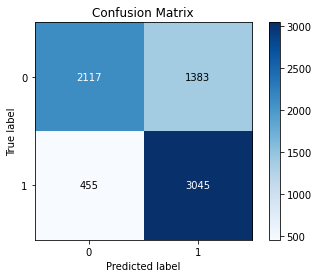

In [ ]:
#best_model = model_list[acc_list.index(max(acc_list))]
#best_score = best_model.evaluate(test_X, test_y, verbose= 0)
#print(len(best_score))
#print('Accuracy on test:', best_score[2])
model_evaluation_plt(model_1, test_X, test)

### Save and load model

In [ ]:
!mkdir -p saved_model

In [ ]:
best_model.save('/content/drive/MyDrive/Yan/saved_model/best_final')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Yan/saved_model/best_final/assets


In [ ]:
model_1 = tf.keras.models.load_model('/content/drive/MyDrive/Yan/saved_model/best_final')
predicts=model_1.predict(test_X)
predictions=predicts.argmax(1)

In [ ]:
predictions

### prediction result

In [ ]:
predicted_result_c = {}
predicted_result_c['result'] = []
# predict_eval = clf1.predict(x_test).tolist()

for claims, predicted_label in zip(test['sentences'], predictions):
    if predicted_label == 1:
        predicted_result_c['result'].append({
            "predicted_claims": claims,
            "predicted_label": predicted_label
        })

In [ ]:
!pip install xlsxwriter

     |████████████████████████████████| 149 kB 5.1 MB/s 


In [ ]:
data = predicted_result_c['result']
df = pd.DataFrame(data)
writer = pd.ExcelWriter('/content/drive/MyDrive/Yan/predicted_result_c.xlsx', engine='xlsxwriter')
df.to_excel(writer, index = False )
writer.save()

In [ ]:
#Only predict true
predicted_true_c = {}
predicted_true_c['true_result'] = []
y_true = list(test['label'])
for claims, predicted_label, truth in zip(test['sentences'], predictions, y_true):
    if predicted_label == 1 and truth == 1:
        predicted_true_c['true_result'].append({
            "predicted_claims": claims,
            "predicted_label": predicted_label,
            "truth" : truth
        })

In [ ]:
data = predicted_true_c['true_result']# 
df = pd.DataFrame(data)
writer = pd.ExcelWriter('/content/drive/MyDrive/Yan/predicted_c.xlsx', engine='xlsxwriter')
df.to_excel(writer, index = False )
writer.save()

In [ ]:
len(predicted_true_c['true_result'])

3030

### model_2_LSTM

In [ ]:
train_X_ = np.expand_dims(train_X, axis=1)
test_X_ = np.expand_dims(test_X, axis=1)

In [ ]:
def wrapper_lstm(name = 'm', w = 1, n_hidden = 1, layer_width = 128, activ_func = 'relu', input_dim = 104):
    
    path =  name
    callbacks = [
    EarlyStopping(monitor='val_acc', patience=0, min_delta=0.01, verbose=100, mode='auto'),
    ModelCheckpoint(filepath = path, monitor='val_acc', verbose=0, \
                                    save_best_only= True, save_weights_only=False, mode='max', period=1),]
    
    model = Sequential() 
    
    if activ_func == 'identity':
        activ_func = None
        
    model.add(LSTM(layer_width, input_dim=input_dim))
    # set number of hidden layer
    for i in range(n_hidden):
        model.add(Dense(units= layer_width, activation= activ_func, input_dim= input_dim)) 
        
    # make sure input_dim is initiated if there's no hidden layer
    if n_hidden == 0:
        input_dim = input_dim
    else:
        input_dim = layer_width
        
    model.add(Dense(2, activation='softmax', input_dim = input_dim)) 
    model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
    history = model.fit(train_X_, train_y, batch_size=32, epochs=50, verbose=0,\
        callbacks=callbacks) 

    score = model.evaluate(test_X_, test_y, verbose= 0)
    print(len(score))
    print('Accuracy on test:', score[1])
#     model_evaluation(model, test_X, test)
    return (model,score[1])

In [ ]:
name = 'nn_default.h5'
m = wrapper_lstm(name)

In [ ]:
model_list_lstm = []
acc_list_lstm = []
for n_hidden in range(1,3):
    for i in [128,256,512, 1024]:
        for f in ['identity', 'tanh', 'relu', 'sigmoid']:
            print('Number of hidden layers:', n_hidden)
            print('Layer width:', i)
            print('Activation function:', f)
            
            m, s = wrapper_lstm(n_hidden = n_hidden, layer_width = i, activ_func = f)
            model_list_lstm.append(m)
            acc_list_lstm.append(s)
            print('-'*28)

In [ ]:
#best model
lstm_best_final = model_list_lstm[acc_list_lstm.index(max(acc_list_lstm))]##layers:2 , width:1024 ,identity

In [ ]:
# evaluate the model
lstm_best_score = lstm_best_final.evaluate(test_X_, test_y, verbose= 0)


In [ ]:
print(lstm_best_score)

f1 score: 0.7725669
precision : 0.71167266
recall: 0.84485716
accuracy: 0.75128573179245


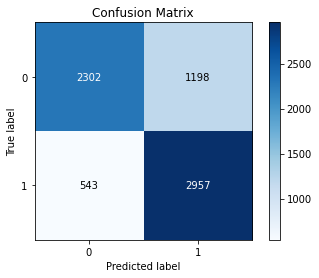

In [ ]:

#print(len(lstm_best_score))
#print('Accuracy on test:', lstm_best_score[1])
model_evaluation_plt(lstm_best_final, test_X_, test)

In [ ]:
!mkdir -p saved_model

In [ ]:
model = lstm_best_final# Number of layers = n_hidden + 2(output layer + LSTM)
model.summary()
print("##Number of layers", len(model.layers))
for layer in model.layers:
    for weight in layer.weights:
        print(weight.name, weight.shape)


Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_30 (LSTM)              (None, 1024)              4624384   
                                                                 
 dense_72 (Dense)            (None, 1024)              1049600   
                                                                 
 dense_73 (Dense)            (None, 1024)              1049600   
                                                                 
 dense_74 (Dense)            (None, 2)                 2050      
                                                                 
Total params: 6,725,634
Trainable params: 6,725,634
Non-trainable params: 0
_________________________________________________________________
##Number of layers 4
lstm_30/lstm_cell_30/kernel:0 (104, 4096)
lstm_30/lstm_cell_30/recurrent_kernel:0 (1024, 4096)
lstm_30/lstm_cell_30/bias:0 (4096,)
dense_72/kernel:0 (1024

In [ ]:
lstm_best_final.save('/content/drive/MyDrive/Yan/saved_model/lstm_best_final')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Yan/saved_model/lstm_best_final/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Yan/saved_model/lstm_best_final/assets


In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/Yan/saved_model/lstm_best_final')
predicts=model.predict(test_X_)
predictions=predicts.argmax(1)

# data_cleaning_word2vec

In [ ]:
import nltk, os, gensim
import numpy as np
import pandas as pd

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
claimDF_train = pd.read_csv("/content/drive/MyDrive/Yan/IBM_Debater_(R)_CS_EACL-2017.v1/claim_stance_dataset_v1.csv")
print (claimDF_train[:1].T)
with open('/content/drive/MyDrive/Yan/IBM_Debater_(R)_CS_EACL-2017.v1/articles/t1/clean_1.txt') as f:
    train_text = f.read()
    print(len(train_text))
    #print (test[400: 568])

                                                                                0
topicId                                                                         1
split                                                                        test
topicText                       This house believes that the sale of violent v...
topicTarget                             the sale of violent video games to minors
topicSentiment                                                                 -1
claims.claimId                                                               2973
claims.stance                                                                 PRO
claims.claimCorrectedText       Exposure to violent video games causes at leas...
claims.claimOriginalText        exposure to violent video games causes at leas...
claims.article.rawFile                                      articles/t1/raw_1.txt
claims.article.rawSpan.start                                                  490
claims.article.r

In [ ]:
claimDF_test = pd.read_excel("/content/drive/MyDrive/Yan/IBM_Debater_(R)_CE-ACL-2014.v0/2014_7_18_ibm_CDCdata(cleaned_2).xlsx")
print (claimDF_test[:1].T)
with open('/content/drive/MyDrive/Yan/IBM_Debater_(R)_CE-ACL-2014.v0/wiki12_articles/2007_Burmese_anti-government_protests') as f:
    test_text = f.read()
    print(len(test_text))
    #print (test[418: 568])

                                                                     0
Topicc                      the sale of violent video games to minors 
Article                                       Video_game_controversies
Claim                exposure to violent video games causes at leas...
Requires correction                                               True
Correction type                                                    NaN
Corrected Text       Exposure to violent video games causes at leas...
66235


In [ ]:
# functions from https://www.kaggle.com/reiinakano/basic-nlp-bag-of-words-tf-idf-word2vec-lstm
class MyTokenizer:
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        transformed_X = []
        for document in X:
            tokenized_doc = []
            for sent in nltk.sent_tokenize(document):
                tokenized_doc += nltk.word_tokenize(sent)
            transformed_X.append(np.array(tokenized_doc))
        return np.array(transformed_X)
    
    def fit_transform(self, X, y=None):
        return self.transform(X)

class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(word2vec.wv.syn0[0])

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = MyTokenizer().fit_transform(X)
        
        return np.array([
            np.mean([self.word2vec.wv[w] for w in words if w in self.word2vec.wv]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])
    
    def fit_transform(self, X, y=None):
        return self.transform(X)

In [ ]:
class MySentences(object):
    """MySentences is a generator to produce a list of tokenized sentences 
    
    Takes a list of numpy arrays containing documents.
    
    Args:
        arrays: List of arrays, where each element in the array contains a document.
    """
    def __init__(self, *arrays):
        self.arrays = arrays
 
    def __iter__(self):
        for array in self.arrays:
            for document in array:
                for sent in nltk.sent_tokenize(document):
                    yield nltk.word_tokenize(sent)

def get_word2vec(sentences, location):
    """Returns trained word2vec
    
    Args:
        sentences: iterator for sentences
        
        location (str): Path to save/load word2vec
    """
    if os.path.exists(location):
        print('Found out {}'.format(location))
        model = gensim.models.Word2Vec.load(location)
        return model
    
    print('{} not found. training model'.format(location))
    model = gensim.models.Word2Vec(sentences, size=100, window=5, min_count=5, workers=4)
    print('Model done training. Saving to disk')
    model.save(location)
    return model



In [ ]:

w2vec = get_word2vec(MySentences([train_text]), '/content/drive/MyDrive/Yan/w2vmodel')
w2vec = get_word2vec(MySentences([test_text]), '/content/drive/MyDrive/Yan/w2vmodel')

Found out /content/drive/MyDrive/Yan/w2vmodel
Found out /content/drive/MyDrive/Yan/w2vmodel


In [ ]:
all_docs = []
for root, dirs, files in os.walk("/content/drive/MyDrive/Yan/IBM_Debater_(R)_CE-ACL-2014.v0/"):
    for file in files:
        #if 'clean' in file:
        file_name = os.path.join(root, file)
        #print(root)
        #print(file_name)
        with open(file_name,encoding='gb18030',errors='ignore') as f:
            text = f.read()
            all_docs.append(text)

In [ ]:
print (len(all_docs))
for i, a in enumerate(all_docs):
    print (i, len(a))
get_word2vec(MySentences(all_docs), '/content/drive/MyDrive/Yan/w2vmodel')

In [ ]:
mean_embedding_vectorizer = MeanEmbeddingVectorizer(w2vec)
print(mean_embedding_vectorizer)
mean_embedded = mean_embedding_vectorizer.fit_transform(test)

In [ ]:
print (len(mean_embedded))
mean_embedded[0]

#data

In [ ]:
import gensim

def get_word2vec(sentences, location):
    """Returns trained word2vec
    
    Args:
        sentences: iterator for sentences
        
        location (str): Path to save/load word2vec
    """
    if os.path.exists(location):
        print('Found {}'.format(location))
        model = gensim.models.Word2Vec.load(location)
        return model
    
    print('{} not found. training model'.format(location))
    model = gensim.models.Word2Vec(sentences, size=100, window=5, min_count=5, workers=4)
    print('Model done training. Saving to disk')
    model.save(location)
    return model

In [ ]:
mean_embedding_vectorizer = MeanEmbeddingVectorizer(w2vec)

In [ ]:
print (test)